In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import sys

from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import multivariate_normal

sys.path.append("../")
import vuong_tests8 as vuong_tests_fast

In [2]:
class JointNormal1(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([params[0], 0.0], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())
    
    
class JointNormal2(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([0.0, params[0]], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())


def setup_shi(yn,xn):
    # model 1 grad, etc.
    nobs = yn.shape[0]
    model1_param = np.array([yn.mean()])
    model2_param = np.array([xn.mean()])
    
    model1_deriv = JointNormal1(yn,xn)
    ll1 = model1_deriv.loglikeobs(model1_param)
    grad1 =  model1_deriv.score_obs(model1_param).reshape( (nobs,1) )
    hess1 = model1_deriv.hessian(model1_param)
    
    
    model2_deriv = JointNormal2(yn,xn)
    ll2 = model2_deriv.loglikeobs(model2_param)
    grad2 =  model2_deriv.score_obs(model2_param).reshape( (nobs,1) )  
    hess2 = model2_deriv.hessian(model2_param)
    
    return ll1,grad1,hess1,model1_param,ll2,grad2,hess2,model2_param

def gen_data(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([beta,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

yn,xn,nobs = gen_data()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi(yn,xn)
print(grad1.shape,hess1.shape)
#NOTE! Weird size distortions with shi's test when theta = .5....

(1000, 1) (1, 1)


In [3]:
nsims= 700
trials =1000
skip_boot=False
skip_shi=False
refinement_test=True
linspace=40
smoothing =5
adapt_c= True


calc_c =lambda nobs: (nobs**(-1/4)/np.sqrt(nobs), .1*(nobs+10)**(-1/3))
print(calc_c(200))

(0.018803015465431967, 0.016823908657399744)


# Size stuff

In [4]:
betas = np.linspace(0,3,linspace)
nobs = 500
c1,c2 = calc_c(nobs)

results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])
    print(beta,boot3)

-1.4911907922045498 -0.6106434697755212 2.18239088684873
-2.3863679526036465 -0.6106434697755212 1.2872137264496326
---
-1.6372573467121527 0.8142514800437707 1.9611868979023077
-1.8681429292651388 0.8142514800437707 1.7303013153493216
---
-1.8219703524767017 0.646662525968388 2.045724151561658
-2.097832277908129 0.646662525968388 1.7698622261302306
---
-1.398931968342086 -0.4455265373149857 2.2164532482911348
-2.2018721983888887 -0.4455265373149857 1.4135130182443323
---
-1.6421625963785278 -0.47588153096807845 2.318628874767823
-2.412189737840451 -0.47588153096807845 1.5486017333059001
---
-1.7505927019872132 0.2819885929544202 2.085734635297265
-2.144647074802365 0.2819885929544202 1.6916802624821132
---
-1.6986559804986234 0.06280743171621239 2.133315127397183
-2.141403417706898 0.06280743171621239 1.6905676901889084
---
-1.7346872364741361 0.43591751981540483 2.161142984758062
-2.043372362030585 0.43591751981540483 1.8524578592016132
---
-1.574444052289594 -0.6614700734270336 2.41

-1.3071148143851143 -1.348567600133167 2.6904302845608137
-2.5416958644018224 -1.348567600133167 1.455849234544106
---
-0.6752550554695042 -3.604392559443404 3.1857679335857245
-3.035430144531268 -3.604392559443404 0.8255928445239602
---
-1.6449950213551645 0.11488759635864325 2.1581569680651307
-2.061749610138692 0.11488759635864325 1.7414023792816034
---
-1.6298014582275702 -0.9389071593884032 2.330822126102612
-2.387605188085183 -0.9389071593884032 1.573018396244999
---
-1.4340203567285608 -1.2083659468143606 2.4611185980441364
-2.2990076524236707 -1.2083659468143606 1.5961313023490262
---
-1.8345406275575398 0.23219652057340506 2.224603670529127
-2.15478689798763 0.23219652057340506 1.904357400099037
---
-0.7259679947992894 -2.9415255360639136 3.115852061617976
-3.2629239193560107 -2.9415255360639136 0.5788961370612544
---
-1.427829936995947 -0.6787012714558885 2.344244809866783
-2.221875047381188 -0.6787012714558885 1.5501996994815417
---
-1.66282066763915 0.08011857399102855 2.12

-1.8158796821356662 0.26184359221651715 2.1388145604401414
-2.1203511646483113 0.26184359221651715 1.8343430779274965
---
-1.7210466526946078 -1.3947442011717783 2.114044570044508
-2.2031307626150176 -1.3947442011717783 1.6319604601240973
---
-2.0469503709947783 1.5419563789015496 2.042112261304541
-2.1664675289256636 1.5419563789015496 1.9225951033736557
---
-1.5655637573339718 -0.6201520121859362 2.300165494170315
-2.103381669671732 -0.6201520121859362 1.7623475818325547
---
0.3076923076923077 [0.83714286 0.         0.16285714]
-1.4360774906904432 -5.357993994175401 2.4085873531281616
-2.4687839070249398 -5.357993994175401 1.3758809367936653
---
-1.7671024029709794 -2.1428003536637394 2.085540108833768
-2.433322764270696 -2.1428003536637394 1.4193197475340515
---
-1.641558649345818 -0.2550456606751137 2.2013286425046945
-1.8667845792435414 -0.2550456606751137 1.9761027126069712
---
-1.8661359682333996 0.030880925249615068 2.1422355747545487
-2.1344923188988836 0.030880925249615068 1.

-1.8143749748119964 -3.5476813500243605 2.210882275823043
-2.337098082153987 -3.5476813500243605 1.6881591684810529
---
-1.6701497093044455 -2.5547308881721147 2.243093250549382
-2.181101094384409 -2.5547308881721147 1.732141865469418
---
-1.6669635961694624 -0.8911689810306924 2.182051258609798
-1.9707094857812197 -0.8911689810306924 1.8783053689980402
---
-1.7629963184125075 -0.977054934331473 2.0421752875874186
-2.0318852745041958 -0.977054934331473 1.7732863314957303
---
-2.0075394805930395 0.6432800441369411 2.1837256826495
-2.1679937654319605 0.6432800441369411 2.023271397810579
---
-1.5369203233979278 -5.318605118449953 2.2738973886516187
-2.3018982400590624 -5.318605118449953 1.508919471990484
---
-1.726268294760602 -2.8389693578081903 2.154470269360773
-2.188340842059947 -2.8389693578081903 1.6923977220614281
---
-1.9387405763004508 -0.20056723476293808 2.0272649081103014
-2.1414338398303046 -0.20056723476293808 1.8245716445804476
---
-1.930252575605853 1.0232141558357852 1.96

-2.05140190193674 -0.7902027503006128 1.952748934628096
-2.254082264851776 -0.7902027503006128 1.7500685717130606
---
-1.854565793928794 -0.4068323097127307 2.096979910320047
-2.0394443920240826 -0.4068323097127307 1.9121013122247588
---
-1.9057711040501457 -0.78935659477359 2.109456581862031
-2.123974718767713 -0.78935659477359 1.891252967144464
---
-1.7936418923631698 -0.6185776191692384 1.9264796101041592
-1.9871185490583605 -0.6185776191692384 1.7330029534089686
---
-1.7828621043309505 -1.4417831644981014 2.0587253317793546
-2.0181714505107227 -1.4417831644981014 1.8234159855995826
---
-1.903447914969758 1.3023230227165694 1.995924439781276
-2.0050464296756165 1.3023230227165694 1.8943259250754176
---
-2.1009679393343896 0.30697852040470025 2.1129537028670984
-2.2417871198862356 0.30697852040470025 1.9721345223152527
---
-1.8453779464505071 -1.6231736898355598 2.1110410436878135
-2.106616053469928 -1.6231736898355598 1.8498029366683928
---
-1.8680493445749193 0.5580517923906236 1.9

-1.7993021636929922 -1.9705329456494607 1.9577687489623514
-1.9910149473599852 -1.9705329456494607 1.7660559652953585
---
-1.926072870006187 -1.293783000042639 2.0033637596033276
-2.074529300519211 -1.293783000042639 1.8549073290903038
---
-1.9230751996731772 -0.04910312414943985 1.9587934947952752
-2.039162754219352 -0.04910312414943985 1.8427059402491002
---
-1.8829815274331696 -0.5378601697425706 1.9116474418130733
-2.0200702722629913 -0.5378601697425706 1.7745586969832516
---
-1.8191476878138708 0.4901949808289607 1.984175193528574
-1.9347085650237799 0.4901949808289607 1.868614316318665
---
-1.878395088176586 0.5010716924714042 1.9696371812426867
-1.9878159720023774 0.5010716924714042 1.8602162974168954
---
-1.8306832227219263 -1.96370843466319 1.9379717707835327
-2.0039040627350615 -1.96370843466319 1.764750930770398
---
-1.8788261345282207 -0.7812853630991247 2.024372638626317
-2.0132736075349635 -0.7812853630991247 1.889925165619574
---
-1.9794148993102474 1.171645435495508 1.9

-1.7892490613944116 -0.6222761993885946 2.024513535671873
-1.9076384348937698 -0.6222761993885946 1.9061241621725147
---
-1.9731065468909088 -0.28384366075930195 2.0633679654304027
-2.076503182124553 -0.28384366075930195 1.9599713301967583
---
-1.8313052968534718 0.9647104251638645 2.1606770650888585
-1.9250534100264398 0.9647104251638645 2.066928951915891
---
-1.7778105322478 -0.4149263577931181 1.8946700779315917
-1.8757616318751633 -0.4149263577931181 1.7967189783042283
---
-1.922454691681231 0.2810930221234766 2.060518230926391
-2.0194593815041673 0.2810930221234766 1.9635135411034552
---
-1.8496802674757704 0.8521613316351857 1.9981511910472654
-1.9274794230938344 0.8521613316351857 1.9203520354292014
---
-1.7481101353080624 -2.6132164994885314 2.197460260125174
-1.9183669481963566 -2.6132164994885314 2.02720344723688
---
-1.8192310233815145 0.4141205133306518 1.9432362838225001
-1.914016453838553 0.4141205133306518 1.8484508533654618
---
-1.9910963946417062 1.1079988827741498 2.0

-2.075050619523621 0.8130204922595429 2.1334951204131407
-2.1521080544833247 0.8130204922595429 2.056437685453437
---
-1.618136247009027 -0.7579209129356101 2.072189323393759
-1.7224142874738282 -0.7579209129356101 1.9679112829289582
---
1.2307692307692308 [0.92142857 0.01142857 0.06714286]
-2.036220624183636 -0.6059926280662506 1.9434416251555302
-2.125526877413057 -0.6059926280662506 1.8541353719261087
---
-1.9808018509049532 -0.9260505107002759 1.9297002103625938
-2.082645774417026 -0.9260505107002759 1.827856286850521
---
-1.8195724564345164 -0.3092451731327285 1.9862086771893253
-1.9060338741756135 -0.3092451731327285 1.899747259448228
---
-1.9242196248814278 0.7676906262113321 2.1226110410786627
-1.9963196751221535 0.7676906262113321 2.0505109908379366
---
-1.8484619273342922 0.8464742222707808 1.9933069527625815
-1.922123150732664 0.8464742222707808 1.9196457293642097
---
-1.8812156877571442 0.39128587535541093 1.9166531203915171
-1.9493592219937947 0.39128587535541093 1.8485095

-1.8813613432801377 0.28631045937836547 1.8475740197798494
-1.954780436792006 0.28631045937836547 1.774154926267981
---
-1.7851730911195667 0.2802412314790013 2.114583079496927
-1.859722635746227 0.2802412314790013 2.0400335348702665
---
-1.9434597830157665 -0.8793631995163672 1.93407338338041
-2.026551328527067 -0.8793631995163672 1.8509818378691099
---
-1.9328247310010434 0.18115681155668595 1.9923845804607612
-2.011561437884159 0.18115681155668595 1.913647873577645
---
-1.8554783470878713 1.0821728735007605 2.0744267783485246
-1.9229073360905022 1.0821728735007605 2.0069977893458932
---
-1.8748951042807216 -2.1162632191014965 2.0017554297891413
-1.9725985187511463 -2.1162632191014965 1.9040520153187162
---
-1.9393900338524201 -1.3241671605418353 1.9582167522569462
-2.0291563404706854 -1.3241671605418353 1.8684504456386808
---
-2.007254638810746 -0.5353050068888748 2.033005544198174
-2.0910830194482406 -0.5353050068888748 1.9491771635606796
---
-1.914536324660421 -1.534423018369391 2

-1.981321728641559 -0.3508115465916183 2.0956895585685986
-2.0478605179117535 -0.3508115465916183 2.029150769298404
---
-1.8430121651481295 1.4493828976924408 2.0060772849339314
-1.8974675175824587 1.4493828976924408 1.9516219324996018
---
-1.9864421045597989 0.3422694896143137 1.9753964783441484
-2.053210397786636 0.3422694896143137 1.9086281851173112
---
-1.9059422834925392 -0.29680303562425153 2.024573090226977
-1.9760897449848152 -0.29680303562425153 1.9544256287347013
---
-1.820581909457271 0.48979355858310275 1.8894903203343714
-1.8862570137862202 0.48979355858310275 1.8238152160054222
---
-2.0059057765786124 0.6460613245762115 1.9776848577881616
-2.0680028467021545 0.6460613245762115 1.915587787664619
---
-1.7377959921684984 -0.5996368900233292 1.9777349223465677
-1.8166571409136514 -0.5996368900233292 1.8988737736014147
---
1.6153846153846154 [0.93857143 0.01142857 0.05      ]
-1.7607798328485686 0.32416612947147483 2.0112718442129784
-1.824650689558251 0.32416612947147483 1.94

-1.8469932704755143 0.9049816370132362 1.9138373545530243
-1.9003858813997767 0.9049816370132362 1.8604447436287619
---
-1.9403885898645694 -0.27524441814029194 1.865388995109713
-2.0022859324790945 -0.27524441814029194 1.8034916524951876
---
-2.004919836834801 0.2632768824901793 2.0471993879641035
-2.0633640276325385 0.2632768824901793 1.988755197166366
---
-1.9921762972989447 0.07702882986269315 1.9437653220626985
-2.0527941598474047 0.07702882986269315 1.8831474595142386
---
-2.0132888193830913 -0.5388939708355308 2.1750364658530006
-2.077851889783064 -0.5388939708355308 2.110473395453028
---
-1.9592196362800045 -0.9734139196113938 1.9946143088969979
-2.029707260930508 -0.9734139196113938 1.9241266842464946
---
-2.0244582858168347 -1.3222010295387383 1.846143538519521
-2.09241296484829 -1.3222010295387383 1.7781888594880662
---
-2.10159648059389 -0.08773627028515878 2.08022657620297
-2.1617962387627943 -0.08773627028515878 2.0200268180340655
---
-2.0269717718690106 -0.87740472277696

-1.971942578800667 0.4479441443991961 1.8198547581901705
-2.0251375969223746 0.4479441443991961 1.7666597400684632
---
-1.9373614342384016 0.17235086251398826 2.000556740064839
-1.9872980026829425 0.17235086251398826 1.9506201716202978
---
-1.9600694611045537 1.1679568175609207 2.0420598501179814
-2.0110962608001075 1.1679568175609207 1.9910330504224276
---
-2.00539574307104 -0.7239708649383004 1.9356405069808322
-2.0621194211417415 -0.7239708649383004 1.878916828910131
---
-2.008050102112336 -0.19400313437565914 1.92680561468913
-2.0662402337575725 -0.19400313437565914 1.8686154830438932
---
-1.8452279031864813 -0.4851128502107111 1.9619426421115103
-1.9052398049042256 -0.4851128502107111 1.901930740393766
---
-1.9518785416259432 0.13464339345986118 2.031383199301452
-2.004983239668337 0.13464339345986118 1.9782785012590582
---
-2.095445599443195 -1.4778014305947864 2.0985123778767525
-2.161498829687717 -1.4778014305947864 2.0324591476322302
---
-1.7795493732481602 -1.3588105843410292

2.153846153846154 [0.94285714 0.00714286 0.05      ]
-1.8575719787820828 -2.531188766851582 1.9895441400684093
-1.9182506577650533 -2.531188766851582 1.9288654610854388
---
-1.9356175410602847 0.3475320142805391 2.0052125921144275
-1.9839322186203505 0.3475320142805391 1.9568979145543617
---
-1.9292241954032867 0.3468428776237978 1.9545076608993426
-1.9768928340462948 0.3468428776237978 1.9068390222563345
---
-1.95166570211287 0.9975838670131338 1.9818896841429774
-1.9956203418358205 0.9975838670131338 1.937935044420027
---
-1.8990755780243638 1.1811129133524143 1.9160830079042666
-1.9423064444117006 1.1811129133524143 1.8728521415169297
---
-2.120477635635416 -0.23903173591975752 1.936279658932826
-2.1697361735946585 -0.23903173591975752 1.8870211209735834
---
-1.8713384399662403 1.0785365229886332 1.9584203262239317
-1.915593957597838 1.0785365229886332 1.914164808592334
---
-1.8150607614019467 -0.5178189788451991 2.0379309928701894
-1.869423935532935 -0.5178189788451991 1.9835678187

-1.9029688941151806 0.8942457870316737 2.027944966860442
-1.9458550265662113 0.8942457870316737 1.985058834409411
---
-1.8974004728509988 1.3126199543030104 2.0597733111301504
-1.9384117842814403 1.3126199543030104 2.018761999699709
---
-1.935779819862645 -2.003671540942447 1.9801546957937612
-1.9913825400787877 -2.003671540942447 1.9245519755776186
---
-1.8091302483980631 -0.35187982128731293 2.0595663920523593
-1.8585439236674448 -0.35187982128731293 2.010152716782978
---
-1.8878633722954656 0.38427510564221995 2.006773025488946
-1.9344876032843417 0.38427510564221995 1.9601487945000702
---
-1.931561640173863 -0.28730531032055195 1.8521744149250472
-1.9795209208070703 -0.28730531032055195 1.8042151342918398
---
-1.7842350563636902 1.3416769551667773 2.100641132277476
-1.8241834846617693 1.3416769551667773 2.0606927039793974
---
-1.9671813654014774 0.34869023729884574 2.0201393749954017
-2.0103219886180805 0.34869023729884574 1.9769987517787986
---
-2.100126258233835 -0.67758817869734

-1.9467399590086278 -0.6195588155470781 1.9919740553943468
-1.992276328400581 -0.6195588155470781 1.9464376860023935
---
-2.0975699262759266 -0.7497068592097269 1.9732247542114918
-2.1456652445967346 -0.7497068592097269 1.9251294358906834
---
-1.86475595217569 0.4490233356592375 2.167434527733243
-1.9065567374246548 0.4490233356592375 2.125633742484278
---
-2.015199897971238 -0.6529975472742372 1.869179037393504
-2.061712842204662 -0.6529975472742372 1.8226660931600802
---
-2.0763465222738757 1.123117337875022 1.955517360290313
-2.117522563574445 1.123117337875022 1.9143413189897434
---
2.5384615384615388 [0.96285714 0.00857143 0.02857143]
-1.8384877710322116 1.5258193808331726 1.99109584895947
-1.876884011056554 1.5258193808331726 1.9526996089351276
---
-1.8572757721883202 1.0054850360916037 1.9960280948551652
-1.8946579140571334 1.0054850360916037 1.958645952986352
---
-1.9109278496725994 0.4742297601293254 1.956157175830843
-1.9516785396783707 0.4742297601293254 1.9154064858250717
-

-1.8700586947700908 0.6329727803036281 2.0276261832304363
-1.9058861348271046 0.6329727803036281 1.991798743173422
---
-2.0173637885785785 -1.6708593546556547 1.99091898848571
-2.060085615300833 -1.6708593546556547 1.9481971617634555
---
-1.8153097920294583 -2.637155095048921 2.0804320826374036
-1.8634478992680414 -2.637155095048921 2.0322939753988205
---
-1.9204672840626609 -1.9464299726638123 2.072994230729138
-1.9668297908477328 -1.9464299726638123 2.026631723944066
---
-1.9767065664459547 0.13908693581884543 2.072672205595748
-2.0194019849911404 0.13908693581884543 2.0299767870505616
---
-1.9320027191398244 1.3407012768820235 1.8344662415056954
-1.968104088866467 1.3407012768820235 1.7983648717790528
---
-1.8105588507731856 0.3067850533346948 1.9484253342488893
-1.8484105292076327 0.3067850533346948 1.9105736558144422
---
-2.011210286970557 -0.8286337415355949 2.06537381668555
-2.0510584959732867 -0.8286337415355949 2.02552560768282
---
-2.021735393186972 -1.0996949263304767 1.9673

-1.8962626793528017 1.5287149766801031 1.9720933169304882
-1.9319311845398626 1.5287149766801031 1.9364248117434273
---
-1.851267012786517 -0.812196376210346 2.1307188471656398
-1.8900200800729985 -0.812196376210346 2.0919657798791587
---
-1.8498567122989904 -0.6130958716415846 1.9139842725440859
-1.8899590035473 -0.6130958716415846 1.8738819812957763
---
-2.042265605617563 0.5204176217594595 1.9239762776401688
-2.080875539025326 0.5204176217594595 1.885366344232406
---
-2.136315463343045 0.6205217803968373 1.7872115618396334
-2.171527439938473 0.6205217803968373 1.7519995852442054
---
-1.8689281044016908 -0.379954705335664 2.0346787406363145
-1.9090884730265252 -0.379954705335664 1.9945183720114803
---
-2.0234179053785564 -1.3169885864498252 1.9662426398907438
-2.0648694959762333 -1.3169885864498252 1.9247910492930669
---
-1.9095512574819462 0.09745040861636653 2.085330516828173
-1.9480158418741211 0.09745040861636653 2.046865932435998
---
-2.0752119077753286 0.9406344186233652 1.8721

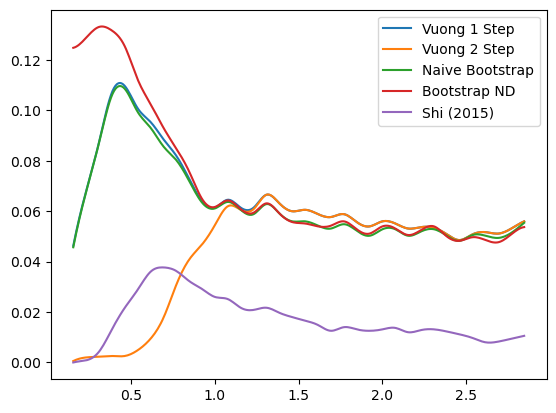

In [5]:
def create_fig(params,res,name='test.png'):
    results2 = np.array(res)
    
    col_labels = ['Param','Vuong 1 Step','Vuong 2 Step', 'Refinement Test','Shi (2015)', 'Naive Bootstrap','Bootstrap TIC','Bootstrap ND']



    np_results = np.concatenate((params.reshape(params.shape[0],1),results2[:,:,0]),axis=1)
    df_results = pd.DataFrame(data=np_results,columns=col_labels)
    df_results.to_csv("paper_figs3/"+name[:-4]+".csv")
    
    ma2 = lambda x : np.convolve(x,np.ones(smoothing)/smoothing, mode='valid')
    params_new = np.linspace( ma2(params).min(),  ma2(params).max(), 300) 
    interp = lambda x: make_interp_spline(ma2(params), ma2(x), k=3)(params_new)


    plt.plot(params_new, interp(1-results2[:,0,0]) ,label='Vuong 1 Step')
    plt.plot(params_new, interp(1-results2[:,1,0]) ,label='Vuong 2 Step')
    
    if not skip_boot:
        plt.plot(params_new,interp(1-results2[:,4,0]),label='Naive Bootstrap')
        plt.plot(params_new,interp(1-results2[:,6,0]),label='Bootstrap ND')
        
    if not skip_shi:
        plt.plot(params_new,interp(1-results2[:,3,0]),label='Shi (2015)')

    plt.legend()
    plt.savefig('paper_figs3/'+name,dpi=300)
    plt.show()

name = 'size_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)

# Power stuff

-1.617198656945337 -1.6105230733606566 2.225069841997294
-2.254386444177966 -1.6105230733606566 1.5878820547646648
---
-1.9667390587767704 0.7581873943723567 1.9941494417756074
-2.0524719328093854 0.7581873943723567 1.908416567742992
---
-1.7612113686134172 -0.04014870827325718 2.1220564063128835
-1.9257799031314333 -0.04014870827325718 1.9574878717948672
---
-1.9246674534601595 0.029724771233907998 1.9768952039777405
-2.063546533509715 0.029724771233907998 1.838016123928185
---
-1.868186820531286 -0.07648273007326044 1.9903249350848873
-2.0518929800670933 -0.07648273007326044 1.8066187755490797
---
-1.7507522222493792 -0.290018930172323 2.0921990165325997
-1.9593723250836392 -0.290018930172323 1.8835789136983399
---
-1.8706157301355588 -0.4254169458127673 2.0913310752792
-2.0991430807216966 -0.4254169458127673 1.862803724693062
---
-1.712584342345815 -2.0211910759709046 2.22597932895011
-2.359029999495156 -2.0211910759709046 1.5795336718007689
---
-2.0294247366543 -0.02429479318017901

-1.7623348352746602 -0.2271800297309656 2.2446855662232843
-1.9831762858586846 -0.2271800297309656 2.02384411563926
---
-2.016088574682051 -0.282130434645959 2.078537962716592
-2.2144502816584604 -0.282130434645959 1.880176255740183
---
-1.7652368115242638 -1.262973227451039 2.1964045905977647
-2.214320118330902 -1.262973227451039 1.747321283791127
---
-1.9553754073508791 0.16486944397595882 2.0360358053192353
-2.091255062045184 0.16486944397595882 1.9001561506249303
---
-1.8686615731339467 0.3271566241778449 1.9913249151903072
-2.0045563818221526 0.3271566241778449 1.8554301065021015
---
-1.9376973613431459 -0.7696531837865094 2.2247625585331194
-2.249506695780057 -0.7696531837865094 1.9129532240962084
---
-1.1533519628958433 -4.6479847144115105 2.6298436488653745
-2.6283033607704946 -4.6479847144115105 1.1548922509907231
---
-1.8090434608908608 -0.18357129892643642 2.213098770498043
-2.0183697430144183 -0.18357129892643642 2.003772488374485
---
-1.9959438565140233 -0.1290214074240793

-1.7099831664322334 -2.3521946684964874 2.01276041771648
-2.1922461292856297 -2.3521946684964874 1.5304974548630836
---
-1.720301703598901 -2.7472524473428286 2.1525169910874995
-2.514953989681551 -2.7472524473428286 1.3578647050048493
---
-2.1341002462068337 -0.04844580486499144 1.9249533357666457
-2.2628927328045574 -0.04844580486499144 1.7961608491689216
---
-1.7661745972230247 -1.2810622546658463 2.1723113516560244
-2.2303229121902426 -1.2810622546658463 1.7081630366888065
---
-1.8875709161298995 0.27092311877763847 2.103228210641308
-1.9993217138786477 0.27092311877763847 1.9914774128925594
---
-1.7378216756603704 -0.488246696361864 2.1129069002684155
-1.9226709451244985 -0.488246696361864 1.9280576308042874
---
-1.7033137890190824 -0.267059155287865 2.1164045748534983
-1.8609898099885867 -0.267059155287865 1.9587285538839936
---
-1.9462952629875456 -0.4299728172852789 2.1601722763676725
-2.116571045226639 -0.4299728172852789 1.9898964941285797
---
-2.0277680974736003 -0.344647703

-1.9338908030485409 -1.2260659129830214 2.031329107480025
-2.145281121517647 -1.2260659129830214 1.819938789010919
---
-1.818640519566875 -0.09612811233801742 2.2710204065234314
-1.9382969718674345 -0.09612811233801742 2.1513639542228717
---
-1.836722448045706 -0.23358229185166046 1.9017498254655034
-1.9946286097402293 -0.23358229185166046 1.7438436637709802
---
-1.750594804011772 -0.7827120807781194 2.1780384737332947
-1.952709019870473 -0.7827120807781194 1.9759242578745935
---
-1.6906011825843044 -2.953322840358465 2.0332071888732806
-2.1857651423845383 -2.953322840358465 1.5380432290730466
---
-1.8130215664189817 -3.10802428019877 2.1743926821664634
-2.274704477540145 -3.10802428019877 1.7127097710453
---
-1.8508344939121824 -2.351194651042946 2.078289435929389
-2.467429177921655 -2.351194651042946 1.4616947519199162
---
-1.862704544892305 -2.9294068432037474 2.039739619290908
-2.2937280738757773 -2.9294068432037474 1.6087160903074358
---
-1.9313334372984061 -0.8468952277884945 2.0

-1.8412996925083287 -0.4784204527042712 2.1662309053610684
-1.9917584380732536 -0.4784204527042712 2.0157721597961435
---
-1.8643698553106238 -0.2995547445196026 1.991055997133831
-1.9637664063520546 -0.2995547445196026 1.8916594460924003
---
-1.6851907477303787 -2.950272528164055 1.9592573541470186
-2.0197328311286 -2.950272528164055 1.624715270748797
---
-1.7628303763384081 -1.3946678918606532 2.192350907542194
-2.0342552006616814 -1.3946678918606532 1.9209260832189206
---
-1.7555545980010165 -0.9304941120032563 1.9652642407614689
-1.8951481493581592 -0.9304941120032563 1.8256706894043262
---
-1.7191756571627879 -1.5978200677421668 2.0740100354015794
-1.9071947690402224 -1.5978200677421668 1.885990923524145
---
-1.9205408145630236 -3.24314933708869 1.99683379259914
-2.2100727931796116 -3.24314933708869 1.707301813982552
---
-1.8519812504915554 -5.365795118615229 2.006160195737734
-2.310720303471592 -5.365795118615229 1.547421142757697
---
-1.645449851917873 -2.855372074319502 2.01180

-1.9408127278291574 -2.992758998509965 2.0404354951152746
-2.233871050455369 -2.992758998509965 1.7473771724890628
---
-2.0206952304115564 -4.912499540095084 2.045966393206712
-2.4334259558540197 -4.912499540095084 1.6332356677642488
---
-1.7438034111747112 -3.7238197759197877 2.1492241572175446
-2.2971958735207485 -3.7238197759197877 1.5958316948715068
---
-2.1155847253695494 -0.8793001775986375 2.0773091280703087
-2.218475360060511 -0.8793001775986375 1.9744184933793472
---
-2.0723895843871314 -5.388828876817906 2.1756693689974136
-2.4422587310897828 -5.388828876817906 1.8058002222947624
---
-2.0614961654946335 -2.9795666043996456 2.017231407938798
-2.2878359951040985 -2.9795666043996456 1.7908915783293327
---
-1.8581933277161946 -1.3109094561021724 2.0323025186101784
-2.005133138146193 -1.3109094561021724 1.88536270818018
---
-1.8222561206981374 -3.1476998484802996 2.2438750020290468
-2.120991289658634 -3.1476998484802996 1.9451398330685499
---
-1.4855098726931 -5.829385841340001 1.

-2.25912414772403 -4.296300778308514 2.1052805454094665
-2.4851818534792014 -4.296300778308514 1.8792228396542945
---
-2.3258876252344565 -4.243817746953087 2.2636091883854013
-2.5319017253344724 -4.243817746953087 2.0575950882853853
---
-2.0084140803036146 0.7738650688285069 2.063975413108584
-2.0635737320213554 0.7738650688285069 2.008815761390843
---
-1.830722781615116 0.45475929136048726 1.9781562775017236
-1.9003816984851731 0.45475929136048726 1.9084973606316664
---
-2.037495376291599 -5.01461994818044 2.2157774280631184
-2.3998349286614507 -5.01461994818044 1.8534378756932666
---
-1.857051675847651 -2.447898477662833 2.007722041228918
-2.0379834446660765 -2.447898477662833 1.8267902724104923
---
-2.0395498027777594 -0.5731286656370456 2.040888321797193
-2.1206045614520668 -0.5731286656370456 1.9598335631228863
---
-2.7330831835991236 -5.725482014763662 2.4499174064263314
-3.112663705834995 -5.725482014763662 2.07033688419046
---
-2.0032750572913143 -2.4941604946569944 2.00869951

-2.0142516931561683 -6.717062206045756 1.931277010821996
-2.2999185959892245 -6.717062206045756 1.6456101079889394
---
-2.000085561408041 -0.7111985754596911 1.9879562387662724
-2.094729183045495 -0.7111985754596911 1.8933126171288184
---
-2.0938987833723655 -8.222903064802834 2.2706567220381224
-2.4091909288322215 -8.222903064802834 1.9553645765782666
---
-2.001766388375582 -4.776945621950309 2.019154122156769
-2.279797541562236 -4.776945621950309 1.7411229689701153
---
-2.055552419704122 -0.5870663650882724 2.0581042276568184
-2.1326780288843135 -0.5870663650882724 1.9809786184766274
---
-1.8508376983917376 -0.39204369770241587 1.8911127147167601
-1.9205490141771104 -0.39204369770241587 1.8214013989313873
---
-1.887569215876773 -6.222437529772804 1.6764133887264292
-2.189044746655498 -6.222437529772804 1.3749378579477047
---
-2.6012842804828016 -6.524557486044002 2.138525451338138
-2.8384077121479083 -6.524557486044002 1.901402019673031
---
-2.016995763392608 -1.2088005132987145 1.96

-2.0335351171664264 -4.190470699685064 2.1472272039995164
-2.1948902043713208 -4.190470699685064 1.9858721167946223
---
-1.9271980295592472 -4.67256847113255 1.9297308025620845
-2.1231609873521897 -4.67256847113255 1.733767844769142
---
-2.07398578596724 -6.546526589108299 2.1193958853458903
-2.311087292465979 -6.546526589108299 1.8822943788471511
---
-2.117227376792816 -7.547541065060859 2.0563385976325943
-2.3733694373509047 -7.547541065060859 1.8001965370745054
---
-2.3424606758056568 -7.57873547629728 2.157422871847518
-2.6214135375764265 -7.57873547629728 1.8784700100767484
---
-1.6712468596251342 -5.312146563822666 1.897864545875434
-1.8410394581446075 -5.312146563822666 1.7280719473559607
---
-1.8347071001888047 -4.694979669570795 2.0245315974228233
-2.0079344961723695 -4.694979669570795 1.8513042014392584
---
-2.2605575963682885 -4.180775123372809 2.0446036614389644
-2.408424173062251 -4.180775123372809 1.896737084745002
---
-1.9582267159762259 -3.0264099315778656 1.88063457864

-1.944761416610807 -4.300145678916427 2.0690837148218995
-2.0814345310255926 -4.300145678916427 1.932410600407114
---
-1.9666618400619975 -3.2362830398349427 1.9089340968434867
-2.0723670150047275 -3.2362830398349427 1.8032289219007567
---
-2.2373718800008766 -7.9936717208248025 2.105275919619331
-2.455735519045701 -7.9936717208248025 1.8869122805745069
---
-2.267028814887535 -6.711043514843354 2.1359501770675036
-2.441967666589032 -6.711043514843354 1.9610113253660066
---
-1.9651945692550283 -6.281602501002796 1.9305575489641795
-2.1198490460647412 -6.281602501002796 1.7759030721544666
---
-2.154823163414975 -4.97652316670555 2.311484251950189
-2.3118328482602144 -4.97652316670555 2.1544745671049492
---
-2.149441718030314 -4.912287704553888 2.0833653870033837
-2.2843945426470524 -4.912287704553888 1.9484125623866448
---
-2.1956179783046634 -5.419041540939176 2.008456585216143
-2.3512734229304817 -5.419041540939176 1.8528011405903242
---
-2.008215591739826 -2.1423186639070613 2.0958561

-2.244880806306939 -5.2273863701179 2.076652063741436
-2.3691124026379566 -5.2273863701179 1.9524204674104186
---
-2.090947023325317 -7.1340483650040625 1.954195188106209
-2.2630769162805806 -7.1340483650040625 1.782065295150946
---
-1.9884356926184945 -1.850684428322296 1.9044033508309706
-2.049695755586208 -1.850684428322296 1.843143287863257
---
-2.266357033731449 -7.04820521943748 2.1727733111241587
-2.4405119186060205 -7.04820521943748 1.9986184262495867
---
-1.933426047829262 -5.475243281641176 1.8352006423260407
-2.0782818180322917 -5.475243281641176 1.6903448721230108
---
-1.980693913752745 -1.7600837302035275 1.7575762110405346
-2.050664293583452 -1.7600837302035275 1.6876058312098277
---
-2.2805441216356295 -6.817403341731581 1.9814875185976397
-2.4446811546794533 -6.817403341731581 1.8173504855538158
---
-2.4730754235475523 -7.145010373306038 2.069326505918687
-2.6453691565924258 -7.145010373306038 1.8970327728738134
---
-2.470182066592382 -7.722888282907604 2.20776919453336

-3.0335520627852284 -10.559695996771643 2.6439885008918074
-3.2049493451536937 -10.559695996771643 2.472591218523342
---
-2.3066489738712095 -10.79220389680173 1.9970779386334017
-2.5342933639537275 -10.79220389680173 1.7694335485508836
---
-2.412056549077041 -3.2849914051711258 2.097769700987533
-2.4887278716213985 -3.2849914051711258 2.0210983784431753
---
-2.2175736643664106 -7.730130230403838 2.0437631396980596
-2.369246444994915 -7.730130230403838 1.892090359069555
---
-2.342855066386559 -9.65108360919086 2.1710528996705545
-2.4978442851454967 -9.65108360919086 2.016063680911617
---
-2.36596348003139 -9.439595338077941 2.141169643620255
-2.553719857017502 -9.439595338077941 1.9534132666341428
---
-2.2031483658937008 -6.738039405826983 2.109885634251227
-2.3313428855679845 -6.738039405826983 1.981691114576943
---
-3.2394519222801814 -10.514343146337886 2.408417135463489
-3.412581812114754 -10.514343146337886 2.2352872456289163
---
-2.31295654208938 -8.641741545406777 1.854855603068

-2.478768840361967 -9.782200793848858 2.0734071847801427
-2.6489435568889332 -9.782200793848858 1.9032324682531767
---
-2.0872251516881803 -5.525751659371844 1.9907125771009184
-2.1762037876938463 -5.525751659371844 1.9017339410952525
---
-2.3375656352375356 -6.137505576220323 1.9563591633540272
-2.453605567976569 -6.137505576220323 1.8403192306149934
---
-2.440994388282585 -3.5006737552032994 2.186473552600292
-2.5100470616955755 -3.5006737552032994 2.1174208791873017
---
-2.277576204712323 -7.275714504504065 2.109816469874316
-2.388663875908937 -7.275714504504065 1.9987287986777014
---
-2.2818979940198476 -9.946863527994303 2.029313264107004
-2.4388017245718476 -9.946863527994303 1.8724095335550042
---
-2.1803912061464135 -4.450901040619578 1.834898324926844
-2.272983651843304 -4.450901040619578 1.7423058792299533
---
-2.005037826454311 -5.406098658192794 1.944464936999953
-2.098958321807584 -5.406098658192794 1.8505444416466796
---
-2.850009346067473 -9.063985126300187 2.38248185009

-2.43036197618 -12.12642921576974 2.1184976331669767
-2.5978912350786376 -12.12642921576974 1.9509683742683388
---
-2.944528377268607 -11.655404024570123 2.5066837763042407
-3.0908193885437494 -11.655404024570123 2.3603927650290983
---
-2.5578607054043676 -8.426146557818331 2.117668848002699
-2.6815304101403523 -8.426146557818331 1.9939991432667141
---
-2.865205902969314 -11.363320493189827 2.495143300918189
-3.0390202791490957 -11.363320493189827 2.3213289247384075
---
-2.417650439592963 -11.277379217796103 2.170651103784945
-2.5707721229888705 -11.277379217796103 2.0175294203890375
---
-2.9913792078514296 -9.785318047752662 2.500314472802236
-3.1150148900178953 -9.785318047752662 2.3766787906357703
---
-2.445366954344476 -6.8274509292514205 2.1627654681161204
-2.5368505034629885 -6.8274509292514205 2.0712819189976077
---
-2.1920976656280824 -6.093698647041979 2.0371957015212634
-2.2866107634641986 -6.093698647041979 1.942682603685147
---
-2.163887324567802 -9.440406857348467 1.940343

-2.4319677833266615 -9.766015928696694 2.2574974682353375
-2.547508082506499 -9.766015928696694 2.1419571690555
---
-2.1146270534656577 -2.356628376192611 1.9481035419285349
-2.16490697674042 -2.356628376192611 1.8978236186537731
---
-2.287796566290646 -10.232834231190603 2.043187188701645
-2.4096946364960377 -10.232834231190603 1.9212891184962533
---
-2.99227605216661 -11.063712905910023 2.4073639706462067
-3.1139158561165425 -11.063712905910023 2.285724166696274
---
-3.1007305452248906 -14.330329992268279 2.5809792460215637
-3.2497613712574465 -14.330329992268279 2.431948419989008
---
-2.7499678766867164 -9.345307917653319 2.507589694985712
-2.858772499303209 -9.345307917653319 2.3987850723692192
---
-3.1699640103531124 -13.873423369702763 2.5930142645623
-3.3161177342629022 -13.873423369702763 2.4468605406525104
---
-2.252200194189324 -7.204180884825313 2.109215004934992
-2.357623143181273 -7.204180884825313 2.003792055943043
---
-2.6822747266677682 -12.8969077961249 2.1451789627762

-3.165283134079951 -11.359753437938323 2.3062903010232025
-3.2771492390234993 -11.359753437938323 2.1944241960796544
---
-2.6018975169575445 -11.363220411114353 2.179721837220035
-2.719238466542115 -11.363220411114353 2.0623808876354643
---
-2.1904077175188235 -6.601452219753905 1.9429136337224107
-2.258190714441538 -6.601452219753905 1.8751306367996958
---
-2.7704826689598634 -8.494469751722043 2.255696432680215
-2.856288651327327 -8.494469751722043 2.1698904503127516
---
-2.812411358339283 -12.426507359971701 2.4090414187388354
-2.949985106186855 -12.426507359971701 2.2714676708912633
---
-2.185456906069179 -7.575845766150816 2.120460880579182
-2.2707264306487476 -7.575845766150816 2.0351913559996135
---
-2.664410581815881 -14.188761589328749 2.2243501426699344
-2.804071715141723 -14.188761589328749 2.084689009344092
---
-3.3860127519384102 -13.248440181234386 2.520781959509765
-3.516936865862065 -13.248440181234386 2.38985784558611
---
-2.9045076807764176 -14.508955735756965 2.16267

-2.12124920418019 -10.06395635247952 2.0224317195808705
-2.219197865729641 -10.06395635247952 1.9244830580314192
---
-2.557244113982755 -9.70444513914329 2.3207370986003317
-2.6490502184494527 -9.70444513914329 2.228930994133634
---
-2.420971855132787 -9.805453367453186 1.9939198618335319
-2.5086847909252 -9.805453367453186 1.9062069260411192
---
-2.766637519475041 -14.215914925954607 2.3949713093361997
-2.8847877049509236 -14.215914925954607 2.276821123860317
---
-4.389493751224291 -16.08582552257215 3.3173122632401872
-4.5279283060612725 -16.08582552257215 3.1788777084032054
---
-2.7393723491591477 -11.005854722302074 2.290124381113463
-2.8504960664884966 -11.005854722302074 2.179000663784114
---
-4.2792862878269675 -16.02920004620246 3.0961318340124753
-4.445829371639989 -16.02920004620246 2.929588750199453
---
-3.066493633309661 -15.055389969994838 2.643980285509605
-3.1960278078850655 -15.055389969994838 2.5144461109342005
---
-2.4550828984382917 -4.9752994199176515 2.130598700016

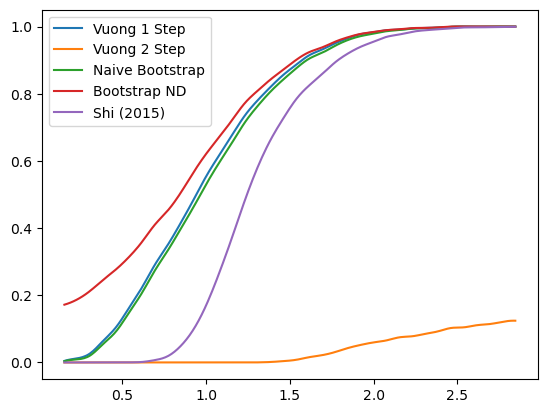

In [6]:
def gen_data3(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([0,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

betas = np.linspace(0,3,linspace)
nobs = 100
c1,c2 = calc_c(nobs)
results = []


for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
    gen_data_ex = lambda : gen_data3(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

name = 'power_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)

# extra size sims

In [ ]:
betas = np.linspace(0,3,linspace)
nobs =250
c1,c2 = calc_c(nobs)
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])
    print(boot3)

name = 'size_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)

-1.4836353519113419 -1.536933124777001 2.328907626768012
-2.3881931863889734 -1.536933124777001 1.424349792290381
---
-1.7271429698404441 0.6865150351823963 2.021570116189569
-1.8885793187787514 0.6865150351823963 1.860133767251262
---
-1.8106958687377264 -0.7834178796431285 2.323951110205357
-2.3625841943521024 -0.7834178796431285 1.7720627845909804
---
-1.600788519705717 -0.8709567564486712 2.355364062542625
-2.288401813338011 -0.8709567564486712 1.667750768910331
---
-1.7803200136969317 -0.369713536503564 2.256194765494327
-2.1745276288604467 -0.369713536503564 1.8619871503308123
---
-1.7702604259568886 0.11033540618855327 2.1241184263110306
-2.0552601568642346 0.11033540618855327 1.8391186954036842
---
-1.6418438049662576 -0.6354503508107857 2.3057989613033714
-2.252563759049335 -0.6354503508107857 1.6950790072202944
---
-1.817797844331466 0.0987140753736292 2.0853992778694295
-2.082032874201096 0.0987140753736292 1.8211642479997998
---
-1.5008290576162213 -0.9591548346203193 2.255

-1.8371870279703502 -0.05660343646559325 1.9647091120254083
-2.1706438760792754 -0.05660343646559325 1.631252263916483
---
-1.8143369811916241 0.4011615031967861 2.127864103812015
-2.023151556327765 0.4011615031967861 1.9190495286758742
---
-1.6348983360843086 -1.5884987033055307 2.189003994499904
-2.2893466708734724 -1.5884987033055307 1.53455565971074
---
-1.3312441802936594 -1.7511071917906615 2.41111618568653
-2.1073796769476862 -1.7511071917906615 1.634980689032503
---
-1.7698461200224491 0.0704619708351195 2.1501810505241283
-2.0749622479617233 0.0704619708351195 1.8450649225848537
---
-1.7120922009144643 -0.380949879605194 2.154464990233344
-2.1224854113301035 -0.380949879605194 1.744071779817705
---
-1.4746613769994585 -1.6244333372166382 2.4009446916678834
-2.481862569611257 -1.6244333372166382 1.3937434990560849
---
-1.6494795380823195 -1.3639826131176938 2.4071623601284418
-2.4599908496549334 -1.3639826131176938 1.596651048555828
---
-1.8366293022955373 0.47597023626507123 2

-1.8645183810979173 -0.15903052242426113 2.1004678032084723
-2.107659923237324 -0.15903052242426113 1.8573262610690655
---
-1.785676104091199 -1.7557643701312655 2.224136440677918
-2.2461209981084496 -1.7557643701312655 1.7636915466606677
---
-1.8526068377003768 -0.6569437488058829 2.145880583208631
-2.1830772876154687 -0.6569437488058829 1.8154101332935395
---
-1.5568665009429274 -2.3244359552420644 2.2550515856915894
-2.2258948159601157 -2.3244359552420644 1.5860232706744006
---
[0.83142857 0.         0.16857143]
-1.9238141093740437 0.5194780642238525 2.0202824345885384
-2.058416969358111 0.5194780642238525 1.8856795746044712
---
-1.7213427676680904 -0.5379393169596417 2.0409135038215194
-1.9773583176883789 -0.5379393169596417 1.7848979538012308
---
-1.8421421468653574 0.7772225033430799 1.9513335047484708
-1.9718733618331534 0.7772225033430799 1.8216022897806747
---
-1.8566895153167151 -0.040501955007953415 1.9669248417668201
-2.0303844708833774 -0.040501955007953415 1.7932298862001

-1.8305771722354558 -0.1294871238957912 2.2378603308700056
-2.006205853787222 -0.1294871238957912 2.0622316493182398
---
-1.889761253003241 0.5010548996244957 2.090381023283502
-1.99294804211825 0.5010548996244957 1.9871942341684932
---
-2.0174985182418896 -0.6167009934997262 1.9797097540869066
-2.229905506962218 -0.6167009934997262 1.7673027653665787
---
-2.0104830504080224 0.815246712944156 1.994157289984836
-2.128525227597022 0.815246712944156 1.8761151127958366
---
-1.8511910807039136 -1.4272191495019044 2.001124332659598
-2.128592668586967 -1.4272191495019044 1.7237227447765449
---
-1.919702411398916 -1.9847019281700566 2.1366550353608575
-2.2843763527820373 -1.9847019281700566 1.7719810939777363
---
-1.7374070649711648 1.3326943829458422 2.0814577164986936
-1.809958516142238 1.3326943829458422 2.008906265327621
---
-1.691127955995758 -3.2556467502192246 2.0223720599371773
-2.1495735567354277 -3.2556467502192246 1.5639264591975075
---
-1.675447920923685 -4.773825768650758 2.053412

-2.0441943373336957 -0.651767697631314 2.0876443639010995
-2.1794812267257027 -0.651767697631314 1.9523574745090928
---
-2.001194556407846 0.47962638608697944 2.0658872881011767
-2.119823333042712 0.47962638608697944 1.9472585114663108
---
-1.8938395300979596 0.39643159579329423 2.0330937703807597
-1.9934049882894396 0.39643159579329423 1.9335283121892797
---
-1.83903769914971 0.098132864446495 1.938647836021424
-1.9717265320646957 0.098132864446495 1.8059590031064383
---
-1.887898268967575 -3.366612126657706 2.1259442702125684
-2.2559670246522274 -3.366612126657706 1.7578755145279163
---
-1.999772650111632 0.11033925544324165 1.9452055656579066
-2.111493245859892 0.11033925544324165 1.8334849699096465
---
-1.8504113309891452 -2.5637267298461612 2.1444593647032213
-2.164035353986004 -2.5637267298461612 1.8308353417063623
---
-1.8395132295153176 0.4270868488426684 1.966792016374726
-1.9340779753277588 0.4270868488426684 1.8722272705622847
---
[0.88142857 0.00142857 0.11714286]
-1.975496

-1.9489824642627063 -0.03207997402781773 1.9137298330140529
-2.0481952588555132 -0.03207997402781773 1.8145170384212461
---
-1.9830750488923483 0.3952883228477139 1.978212385153531
-2.084688352724434 0.3952883228477139 1.8765990813214453
---
-1.966415494622164 -0.5697044182917899 1.9421482739655573
-2.0682332139699953 -0.5697044182917899 1.8403305546177262
---
-1.810491373333648 -1.0852499349901796 1.9287736290097888
-1.9491237375986732 -1.0852499349901796 1.7901412647447636
---
-1.7648828094476863 -2.190633357833905 2.074261989771533
-1.934660024130952 -2.190633357833905 1.9044847750882674
---
-1.876813407056423 0.4444934838542464 1.8824328545918612
-1.963270647189146 0.4444934838542464 1.7959756144591383
---
-2.0850870594536217 -0.6997842061311133 1.8739300991336907
-2.219671221079858 -0.6997842061311133 1.739345937507454
---
-1.8719491787861142 -0.20654900106119325 2.110710391725549
-1.9786298878618407 -0.20654900106119325 2.004029682649823
---
-1.782596222679733 -4.5684569338086565

-1.9555520484880269 0.2963834077474005 2.10838058665608
-2.030234044876222 0.2963834077474005 2.033698590267885
---
-2.107367989522347 -0.2634750525043616 1.9232054713144362
-2.209015758294654 -0.2634750525043616 1.8215577025421292
---
-1.8696819287253525 0.5234351095759922 2.0956401688359585
-1.9573234315918442 0.5234351095759922 2.0079986659694664
---
-1.7812766396149844 0.43214586934652943 1.9270433572071657
-1.8456279691766124 0.43214586934652943 1.8626920276455377
---
-1.8159689373656456 -3.249777467150557 2.194665266456479
-2.017546228640028 -3.249777467150557 1.9930879751820965
---
-1.8572776015979544 1.605100967488161 1.9584944272512936
-1.9113625573279243 1.605100967488161 1.9044094715213238
---
-1.8498673295313866 0.12478083603995804 2.064771894822477
-1.9325604349421466 0.12478083603995804 1.982078789411717
---
-2.034903519687302 -3.635093959556923 2.0140441919062098
-2.2803717077765233 -3.635093959556923 1.768576003816988
---
-2.0337899468128144 1.4066411516894308 2.0717430

[0.92285714 0.00857143 0.06857143]
-1.7587588235854672 -0.8843538783692347 1.952368011072651
-1.8493817674879525 -0.8843538783692347 1.8617450671701656
---
-1.8996018161764316 -2.1584471440063377 1.9247774527361965
-2.024772264620206 -2.1584471440063377 1.7996070042924222
---
-1.965865004317613 -0.35788638446169485 2.0589752881501506
-2.033278996707319 -0.35788638446169485 1.991561295760444
---
-2.108178864083748 -0.890042104398317 2.079568920176399
-2.199423353060854 -0.890042104398317 1.9883244311992938
---
-2.00059134615429 -0.41009711825978956 2.113792481426716
-2.085314272028695 -0.41009711825978956 2.029069555552311
---
-1.8206983945895885 -0.1653864357020402 1.9945686946926495
-1.8875428423375438 -0.1653864357020402 1.9277242469446942
---
-1.861301589720746 -0.44828492242954326 2.0716443643017493
-1.9414096791708633 -0.44828492242954326 1.9915362748516323
---
-1.8689792824541203 -0.8836692287927503 2.0654483006552353
-1.9578091976203973 -0.8836692287927503 1.9766183854889579
---

In [ ]:
betas = np.linspace(0,3,linspace)
nobs = 100
c1,c2 = calc_c(nobs)
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])


name = 'size_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)

# Extra Power Sims

In [ ]:
betas = np.linspace(0,3,linspace)
nobs = 250
c1,c2 = calc_c(nobs)
results = []


for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
    gen_data_ex = lambda : gen_data3(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

name = 'power_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)

In [ ]:

betas = np.linspace(0,3,linspace)
nobs = 500
c1,c2 = calc_c(nobs)
results = []


for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
    gen_data_ex = lambda : gen_data3(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

name = 'power_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)